In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.133:44135")
client

Client Scheduler: tcp://10.32.16.133:44135 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


# Cumulative volume time derivative ($\frac{\partial \mathcal{V}}{\partial t}$) in S Space

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [9]:
xr.set_options(display_style='text')

In [3]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-sose'), consolidated=True)

In [4]:
coords = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700)
dsr = ds.reset_coords(drop=True).roll(XC=700, XG=700)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


## Create xgcm grid

[Xgcm](http://xgcm.readthedocs.io) is a package which helps with the analysis of GCM data.

In [5]:
import xgcm
grid = xgcm.Grid(ds, periodic=('X', 'Y'))
grid

<xgcm.Grid>
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
T Axis (not periodic):
  * center   time
Y Axis (periodic):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

### Entire WG column budget

In [6]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [7]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [17]:
# define bins
salt_bins = np.arange(32, 35.1, 0.1)
delta_salt = salt_bins[1] - salt_bins[0]

In [20]:
# salt distribution in WG region
vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)

salt_dist = histogram(dsr.SALT.isel(**lat_range, **lon_range), bins=[salt_bins],
                       weights=vol, dim=['XC', 'YC', 'Z']).rename({'SALT_bin':'salt_bin'}) / delta_salt
salt_dist.load()

<xarray.DataArray 'histogram_SALT' (time: 438, salt_bin: 31)>
array([[3.20564398e+12, 6.27415084e+12, 6.62323524e+12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.94635750e+11, 4.18523233e+11, 1.07063114e+12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.55483615e+11, 3.68780415e+11, 9.58487926e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.17910241e+11, 9.23223053e+10, 1.50489334e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.70909012e+11, 5.82225766e+10, 5.97615987e+10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.36110642e+11, 1.16522682e+11, 1.32707965e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 34.85 34.95 35.05

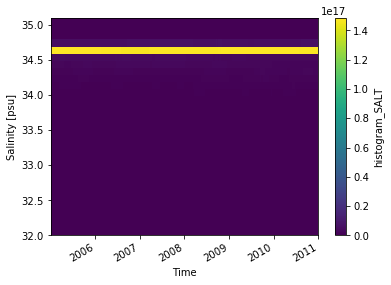

In [24]:
# most of the world's ocean is ~34.6 psu
# very little variability in temp distribution
salt_dist.plot(x='time')

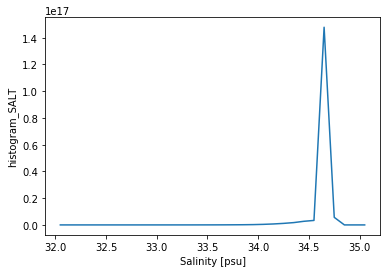

In [25]:
# most of the world's ocean is avg salinity (btwn 34, 35 psu)
salt_dist.mean(dim='time').plot()

Text(0.5, 1.0, 'salt dist anomaly')

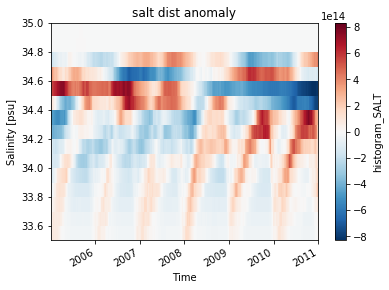

In [26]:
# salt distribution anomaly
(salt_dist - salt_dist.mean(dim='time')).plot(x='time')
plt.ylim([33.5, 35])
plt.title('salt dist anomaly')

# $\frac{\partial \mathcal{V}}{\partial t}$

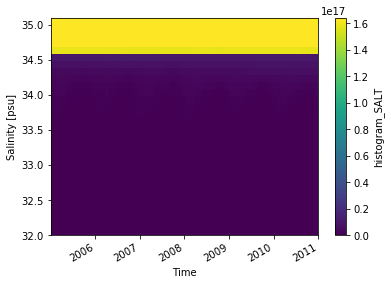

In [28]:
# cumulative volume
V = salt_dist.cumsum(dim='salt_bin')
V.transpose().plot()

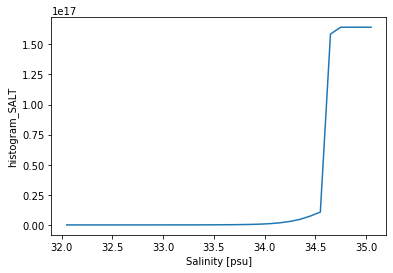

In [29]:
#time avg of cumulative volume
V_mean = V.mean(dim='time')
V_mean.plot()

(33, 34.8)

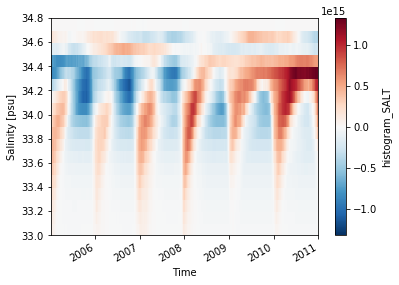

In [30]:
#cumulative volume anomaly
V_anom = V - V_mean
V_anom.plot(x='time')
plt.ylim(33, 34.8)

(33, 35)

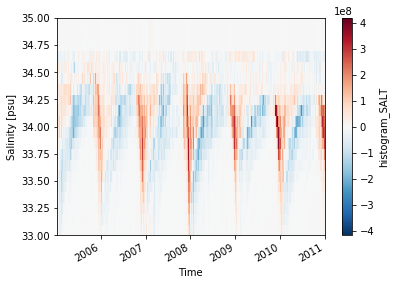

In [32]:
dt = 5*24*60*60
#using V_anom bc there is no change in V_mean
dVdt = V_anom.diff(dim='time') / dt
dVdt.plot(x='time')#, vmax=20e6)
plt.ylim(33, 35)

# $\Psi$

$$
-\int_{\delta R}  (\mathbf{u} \cdot  \hat{\mathbf{n}} ) \mathcal{H}(\tilde S - S)\ dA
$$

$$
= -\int_{\tilde S_{min}}^{\tilde S_{max}} d\tilde S \int_{\delta R}  (\mathbf{u} \cdot  \hat{\mathbf{n}} ) \delta(\tilde S - S)\ dA
$$

### Entire WG column budget

In [33]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [34]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

# <span style='color:Red'> THIS IS WHERE YOU STOPPED to finish `cum-vol-theta` nb

In [20]:
#this is the "dA" part of the equation
u_transport = dsr.UVEL * (coords.dyG * coords.drF * coords.hFacW) #m^3/s
v_transport = dsr.VVEL * (coords.dxG * coords.drF * coords.hFacS) #m^3/s
u_transport

<xarray.DataArray (time: 438, Z: 42, YC: 320, XG: 2160)>
dask.array<mul, shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [21]:
#this is the product of vel components and normal vector part of the equation
u_transport_weddell = u_transport.isel(**lat_range, XG=right_lon)
v_transport_weddell = v_transport.isel(**lon_range, YG=upper_lat)

In [22]:
u_transport_mean_value = u_transport_weddell.mean(dim='time').sum().values
u_transport_mean_value

array(-25396252., dtype=float32)

In [23]:
v_transport_mean_value = v_transport_weddell.mean(dim='time').sum().values
v_transport_mean_value

array(25411532., dtype=float32)

In [24]:
#residual potentially due to E-R-P
residual = u_transport_mean_value + v_transport_mean_value
residual #~0.0153Sv reasonable amount due to precip?

15280.0

In [25]:
#interpolating salt to be on same grid pt as velocity components
salt_at_u = grid.interp(dsr.SALT, 'X')
salt_at_v = grid.interp(dsr.SALT, 'Y', boundary='extend')

In [26]:
salt_uvel = salt_at_u.isel(**lat_range, XG=right_lon)
salt_vvel = salt_at_v.isel(**lon_range, YG=upper_lat)

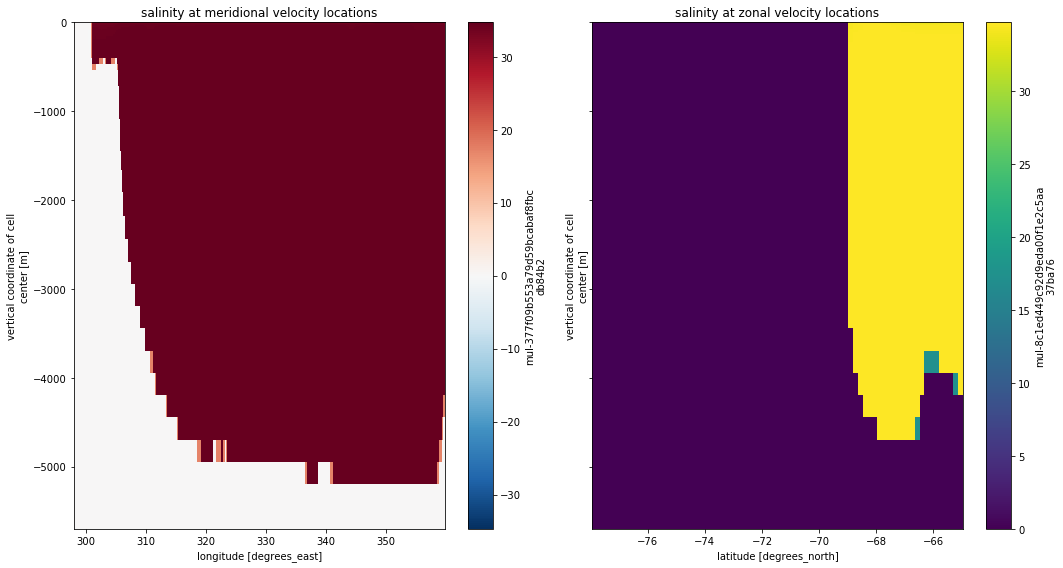

In [45]:
#plt.figure(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=True)

salt_vvel[0].plot(ax=ax1)
#temperature values at vvel values in WG region in timestep:0
ax1.title.set_text('salinity at meridional velocity locations')

salt_uvel[0].plot(ax=ax2)
#temperature values at uvel values in WG region in timestep:0
ax2.title.set_text('salinity at zonal velocity locations')

plt.tight_layout();

In [28]:
uvel = dsr.UVEL.isel(**lat_range, XG=right_lon)
vvel = dsr.VVEL.isel(**lon_range, YG=upper_lat)

/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/srv/conda/envs/notebook/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecatio

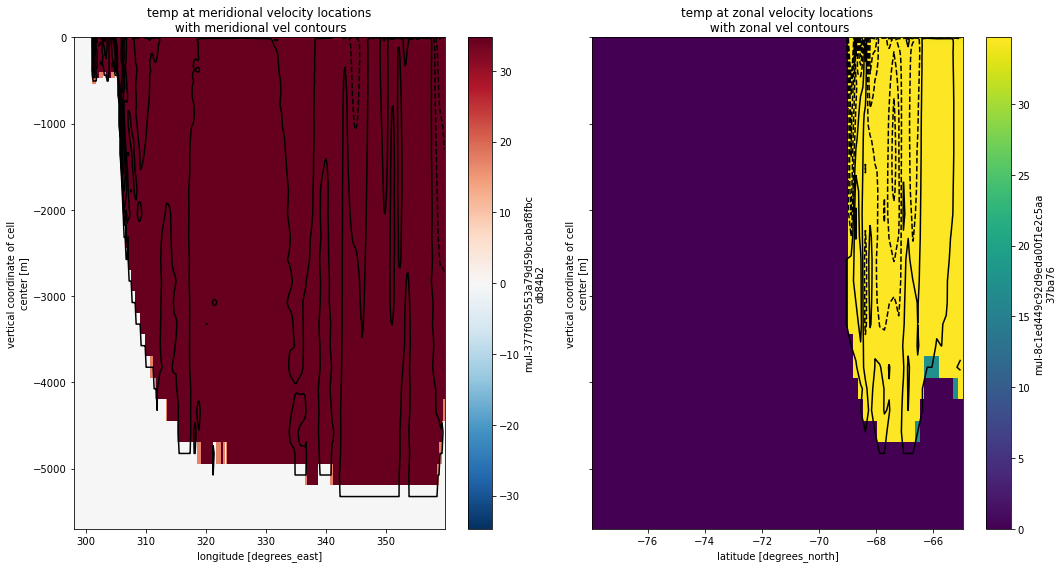

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=True)

salt_vvel[0].plot(ax=ax1)
vvel[0].plot.contour(ax=ax1, colors='k', levels=np.arange(-0.1, 0.1, 0.02))
ax1.title.set_text('temp at meridional velocity locations\n with meridional vel contours')

salt_uvel[0].plot(ax=ax2)
uvel[0].plot.contour(ax=ax2, colors='k', levels=np.arange(-0.1, 0.1, 0.02))
ax2.title.set_text('temp at zonal velocity locations\n with zonal vel contours')

plt.tight_layout();

In [30]:
#this is the delta function part of the equation above
u_binned = histogram(salt_uvel.rename('salt'), bins=[salt_bins],
                     weights=u_transport_weddell, dim=['Z', 'YC'])
v_binned = histogram(salt_vvel.rename('salt'), bins=[salt_bins],
                     weights=v_transport_weddell, dim=['Z', 'XC'])

In [31]:
u_binned

<xarray.DataArray 'histogram_salt' (time: 438, salt_bin: 61)>
dask.array<getitem, shape=(438, 61), dtype=float64, chunksize=(1, 61), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 37.85 37.95 38.05

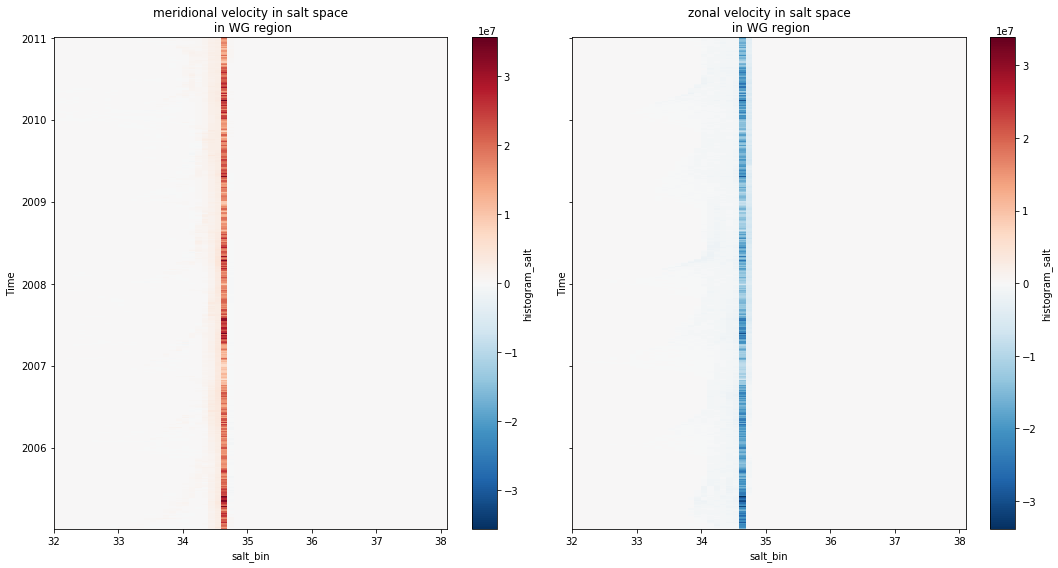

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=True)

v_binned.plot(ax=ax1)
ax1.title.set_text('meridional velocity in salt space\n in WG region')

u_binned.plot(ax=ax2)
ax2.title.set_text('zonal velocity in salt space\n in WG region')

plt.tight_layout();

In [33]:
transport_binned = u_binned + v_binned
transport_binned.load()

<xarray.DataArray 'histogram_salt' (time: 438, salt_bin: 61)>
array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , -348.87683105, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])
Coordinates:
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 37.85 37.95 38.05

In [34]:
transport_binned.max()

<xarray.DataArray 'histogram_salt' ()>
array(9051876.23487246)

(-2000000.0, 2000000.0)

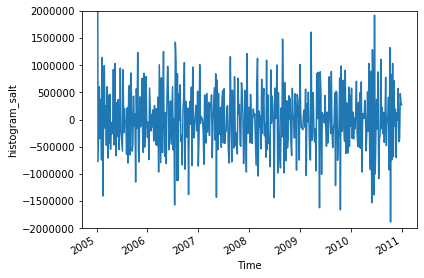

In [35]:
transport_binned.sum(dim='salt_bin').plot()
plt.ylim([-2e6, 2e6])

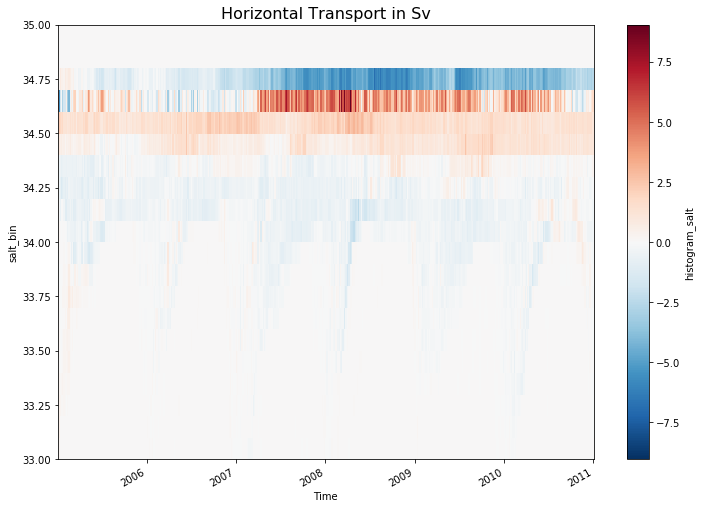

In [44]:
(transport_binned/1e6).transpose().plot(figsize=(12,8))
plt.title('Horizontal Transport in Sv', fontsize=16)
plt.ylim(33,35);

In [37]:
#this is the salt integral part of the equation
transport_weddell = - transport_binned.cumsum(dim='salt_bin')
transport_weddell

<xarray.DataArray 'histogram_salt' (time: 438, salt_bin: 61)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -7.12017399e+06, -7.12017399e+06, -7.12017399e+06],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         7.74179561e+05,  7.74179561e+05,  7.74179561e+05],
       [-0.00000000e+00, -0.00000000e+00,  3.48876831e+02, ...,
         7.90167890e+04,  7.90167890e+04,  7.90167890e+04],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -4.77959688e+05, -4.77959688e+05, -4.77959688e+05],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -3.10393818e+05, -3.10393818e+05, -3.10393818e+05],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -2.72158945e+05, -2.72158945e+05, -2.72158945e+05]])
Coordinates:
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 37.85 37.95 38.05

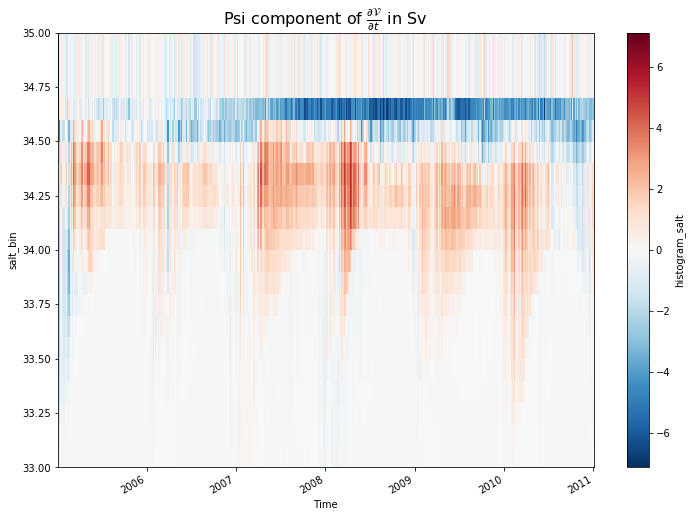

In [43]:
(transport_weddell/1e6).transpose().plot(figsize=(12,8))
plt.ylim(33,35)
plt.title(r'Psi component of $\frac{\partial\mathcal{V}}{\partial t}$ in Sv', fontsize=16);

# $\Omega$

$$
-\int_R \delta(\tilde S - S) \dot S dV
$$

In [39]:
#loading flux ds
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_slt.zarr'))

#loading surface term ds
ds_slt_surf_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_surf_slt.zarr'))

#loading theta and salt ds
t_s = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/t_s.zarr'))

In [41]:
dsr_slt = xr.merge([ds_slt, ds_slt_surf_terms, t_s])
dsr_slt

<xarray.Dataset>
Dimensions:                   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 5.551115e-17 0.16666667 ... 359.83334
  * YG                        (YG) float32 -77.9583 -77.79163 ... -24.791632
  * Zl                        (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    SALT                      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    THETA                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [42]:
#rechunking by `chunksize=ds.shape` of each variable so xhistogram can be happy
ds = dsr_slt.chunk({'XC': -1, 'YC': -1, 'Z': -1})
ds

<xarray.Dataset>
Dimensions:                   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 5.551115e-17 0.16666667 ... 359.83334
  * YG                        (YG) float32 -77.9583 -77.79163 ... -24.791632
  * Zl                        (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    SALT                      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    THETA                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [46]:
ds_slt_wg = dsr_slt.isel(**lat_range, **lon_range)
ds_slt_wg

<xarray.Dataset>
Dimensions:                   (XC: 371, XG: 2160, YC: 78, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 298.08334 298.25 ... 359.58334 359.75
  * YC                        (YC) float32 -77.87497 -77.7083 ... -65.04163
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 5.551115e-17 0.16666667 ... 359.83334
  * YG                        (YG) float32 -77.9583 -77.79163 ... -24.791632
  * Zl                        (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 78, 371), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 78, 371), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    SALT                      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    THETA                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 78, 2160), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 371), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>

### Adv & Diff terms

In [47]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds_slt_wg.SALT.rename('salt'), bins=[salt_bins],
              weights=variable, dim=['XC', 'YC', 'Z'])
    return hist

In [48]:
#this is the delta function part of the equation
fluxes = [ds_slt_wg.conv_horiz_diff_flux_SLT,
          ds_slt_wg.conv_vert_adv_flux_SLT,
          ds_slt_wg.conv_vert_diff_flux_SLT]

fluxes_binned = histogram_func(ds_slt_wg.conv_horiz_adv_flux_SLT.chunk(
                            {'XC': -1, 'YC': -1, 'Z': -1, 'time': 1})).to_dataset(
                                                    name='conv_horiz_adv_flux_SLT')
for var in fluxes:
    new_vars = histogram_func(var.chunk({'XC': -1, 'YC': -1, 'Z': -1, 'time': 1})).rename(var.name)
    fluxes_binned = xr.merge([fluxes_binned, new_vars], compat='override')

In [49]:
fluxes_binned.load()

<xarray.Dataset>
Dimensions:                   (salt_bin: 61, time: 438)
Coordinates:
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * salt_bin                  (salt_bin) float64 32.05 32.15 ... 37.95 38.05
Data variables:
    conv_horiz_adv_flux_SLT   (time, salt_bin) float64 8.352e+05 ... 0.0
    conv_horiz_diff_flux_SLT  (time, salt_bin) float64 4.628e+03 ... 0.0
    conv_vert_adv_flux_SLT    (time, salt_bin) float64 -3.544e+06 ... 0.0
    conv_vert_diff_flux_SLT   (time, salt_bin) float64 1.25e+05 ... 0.0

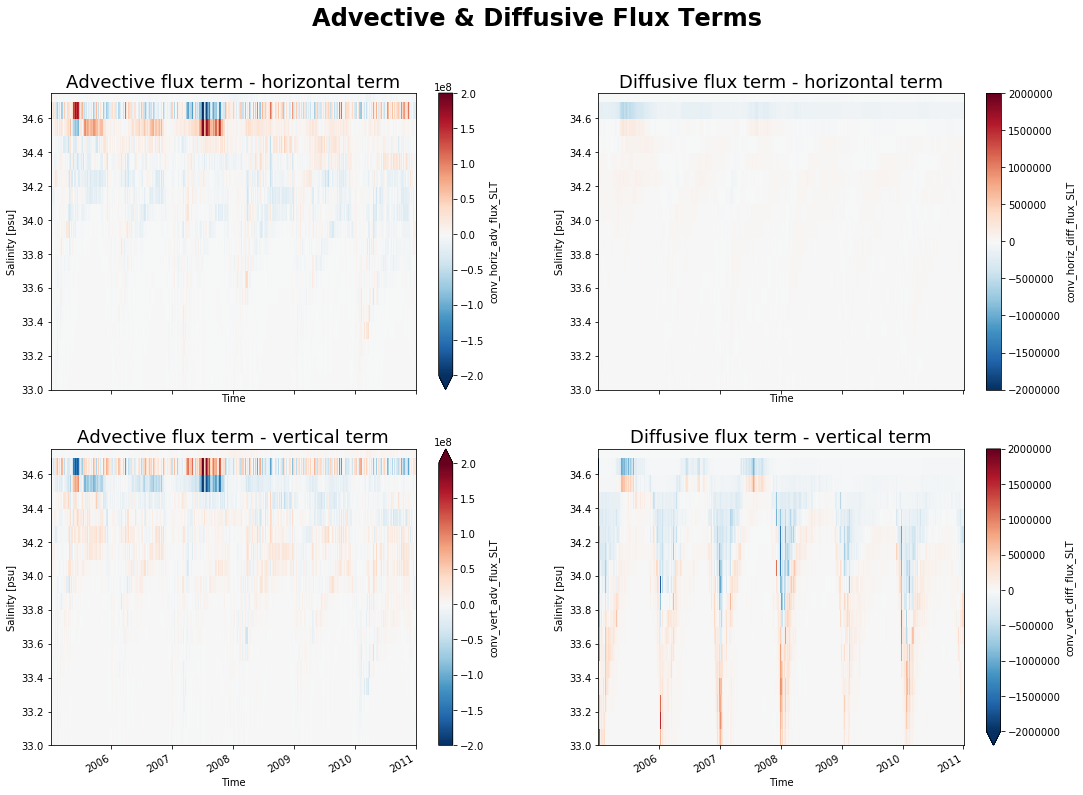

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(18,12), sharex=True)

fluxes_binned.conv_horiz_adv_flux_SLT.transpose().plot(ax=axes[0,0], vmax=200e6)
axes[0,0].set_title('Advective flux term - horizontal term', fontsize=18)
axes[0,0].set_ylim(33, 34.75)

fluxes_binned.conv_horiz_diff_flux_SLT.transpose().plot(ax=axes[0,1], vmax=2e6)
axes[0,1].set_title('Diffusive flux term - horizontal term', fontsize=18)
axes[0,1].set_ylim(33, 34.75)

fluxes_binned.conv_vert_adv_flux_SLT.transpose().plot(ax=axes[1,0], vmax=200e6)
axes[1,0].set_title('Advective flux term - vertical term', fontsize=18)
axes[1,0].set_ylim(33, 34.75)

fluxes_binned.conv_vert_diff_flux_SLT.transpose().plot(ax=axes[1,1], vmax=2e6)
axes[1,1].set_title('Diffusive flux term - vertical term', fontsize=18)
axes[1,1].set_ylim(33, 34.75)

plt.suptitle('Advective & Diffusive Flux Terms', weight='bold', fontsize=24);

### Surface terms

In [51]:
#delta part of the equation
surf_binned = histogram(ds_slt_wg.SALT.isel(Z=0).rename('salt'), bins=[salt_bins],
                        weights=ds_slt_wg.surface_flux_conv_SLT, dim=['XC', 'YC']).load()

lin_fs_binned = histogram(ds_slt_wg.SALT.isel(Z=0).rename('salt'), bins=[salt_bins],
                          weights=ds_slt_wg.lin_fs_correction_SLT, dim=['XC', 'YC']).load()

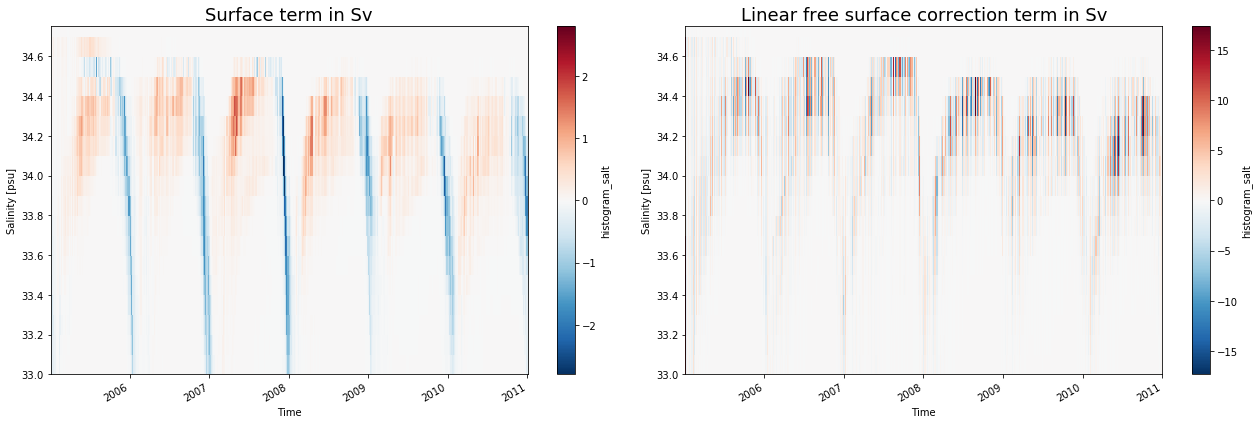

In [52]:
fig, axes = plt.subplots(1,2, figsize=(18,6))


(surf_binned/1e6).transpose().plot(ax=axes[0])
axes[0].set_title('Surface term in Sv', fontsize=18)
axes[0].set_ylim(33, 34.75)

(lin_fs_binned/1e6).transpose().plot(ax=axes[1])
axes[1].set_title('Linear free surface correction term in Sv', fontsize=18)
axes[1].set_ylim(33, 34.75)


plt.tight_layout();

In [53]:
omega = - (fluxes_binned.conv_horiz_diff_flux_SLT + 
           fluxes_binned.conv_vert_diff_flux_SLT +
           surf_binned + 
           lin_fs_binned)
omega

<xarray.DataArray (time: 438, salt_bin: 61)>
array([[-1857606.73482096, -3961399.76676953, -4134960.64791574, ...,
              -0.        ,       -0.        ,       -0.        ],
       [   19421.9248867 ,    38261.69677734,    72067.70196414, ...,
              -0.        ,       -0.        ,       -0.        ],
       [   -9248.41518545,   -10835.28294563,   -17282.27617645, ...,
              -0.        ,       -0.        ,       -0.        ],
       ...,
       [      -0.        ,       -0.        ,       -0.        , ...,
              -0.        ,       -0.        ,       -0.        ],
       [      -0.        ,       -0.        ,       -0.        , ...,
              -0.        ,       -0.        ,       -0.        ],
       [      -0.        ,     6460.39785767,     7334.51215363, ...,
              -0.        ,       -0.        ,       -0.        ]])
Coordinates:
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 37.85 37.95 38.05

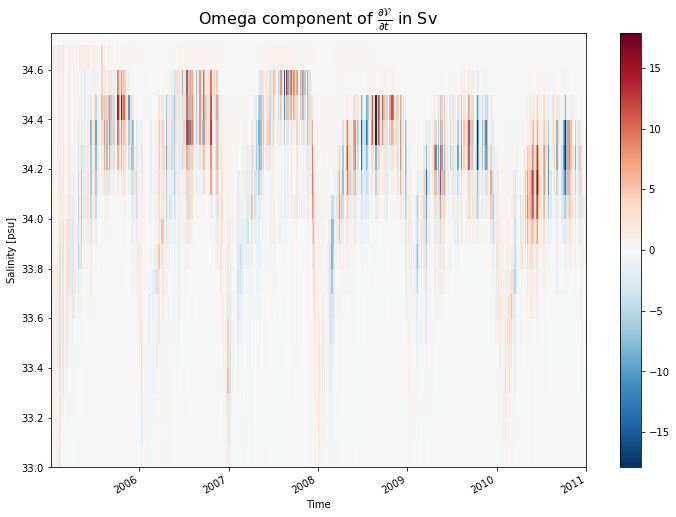

In [54]:
(omega/1e6).transpose().plot(figsize=(12,8))
plt.ylim(33, 34.75)
plt.title(r'Omega component of $\frac{\partial\mathcal{V}}{\partial t}$ in Sv', fontsize=16);

### $\Psi + \Omega$

In [55]:
tendency_term = (transport_weddell + omega)
tendency_term

<xarray.DataArray (time: 438, salt_bin: 61)>
array([[-1.85760673e+06, -3.96139977e+06, -4.13496065e+06, ...,
        -7.12017399e+06, -7.12017399e+06, -7.12017399e+06],
       [ 1.94219249e+04,  3.82616968e+04,  7.20677020e+04, ...,
         7.74179561e+05,  7.74179561e+05,  7.74179561e+05],
       [-9.24841519e+03, -1.08352829e+04, -1.69333993e+04, ...,
         7.90167890e+04,  7.90167890e+04,  7.90167890e+04],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -4.77959688e+05, -4.77959688e+05, -4.77959688e+05],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -3.10393818e+05, -3.10393818e+05, -3.10393818e+05],
       [-0.00000000e+00,  6.46039786e+03,  7.33451215e+03, ...,
        -2.72158945e+05, -2.72158945e+05, -2.72158945e+05]])
Coordinates:
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 37.85 37.95 38.05

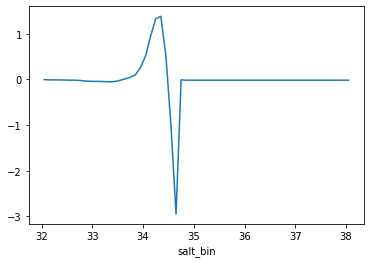

In [56]:
#time_avg to get right of lhs
tendency_term_mean = tendency_term.mean(dim='time')
(tendency_term_mean/1e6).plot()

### $\frac{\int \frac{\partial \mathcal{V}}{\partial t}\ dt}{t - t_0}$

In [57]:
dVdt_time_mean = dVdt.mean(dim='time')
dVdt_time_mean

<xarray.DataArray 'histogram_SALT' (SALT_bin: 61)>
array([-1.68538433e+03, -4.86983865e+03, -7.99374377e+03, -1.09455478e+04,
       -1.44021709e+04, -1.83347981e+04, -2.18086408e+04, -2.52367860e+04,
       -3.01259714e+04, -3.58635916e+04, -4.00240050e+04, -4.43856797e+04,
       -4.99224383e+04, -5.40441848e+04, -5.25794573e+04, -4.73468532e+04,
       -4.02456670e+04, -1.78117432e+04,  3.95218210e+04,  1.21303200e+05,
        2.40194094e+05,  4.13064798e+05,  6.87331530e+05,  1.06392483e+06,
        6.52268983e+05,  9.68206654e+04, -5.34642596e+05,  6.88283672e+02,
        6.88283672e+02,  6.88283672e+02,  6.88283672e+02,  6.88283672e+02,
        6.88283672e+02,  6.88283672e+02,  6.88283672e+02,  6.88283672e+02,
        6.88283672e+02,  6.88283672e+02,  6.88283672e+02,  6.88283672e+02,
        6.88283672e+02,  6.88283672e+02,  6.88283672e+02,  6.88283672e+02,
        6.88283672e+02,  6.88283672e+02,  6.88283672e+02,  6.88283672e+02,
        6.88283672e+02,  6.88283672e+02,  6.88283672e+02,  6.88283672e+02,
        6.88283672e+02,  6.88283672e+02,  6.88283672e+02,  6.88283672e+02,
        6.88283672e+02,  6.88283672e+02,  6.88283672e+02,  6.88283672e+02,
        6.88283672e+02])
Coordinates:
  * SALT_bin  (SALT_bin) float64 32.05 32.15 32.25 32.35 ... 37.85 37.95 38.05

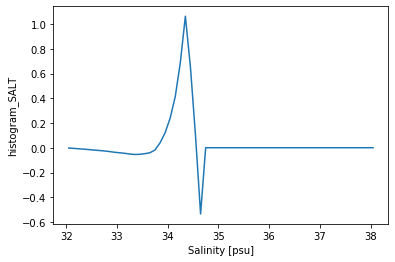

In [58]:
(dVdt_time_mean/1e6).plot()

### $\frac{\int \frac{\partial \mathcal{V}}{\partial t}\ dt}{t - t_0} = \bar{\Psi} + \bar{\Omega}$

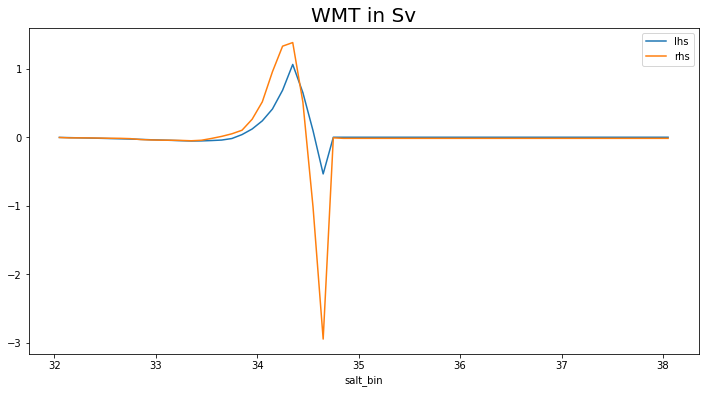

In [59]:
plt.figure(figsize=(12,6))
(dVdt_time_mean/1e6).plot(label='lhs')
(tendency_term_mean/1e6).plot(label='rhs')
plt.legend()
plt.title('WMT in Sv', fontsize=20);